# Plan de Trabajo


Deberás realizar un análisis exploratorio de datos. Al final de Jupyter Notebook, escribe: Una lista de preguntas aclaratorias.

Un plan aproximado para resolver la tarea, que especifica de 3 a 5 pasos básicos y los explica en uno o dos enunciados El líder del equipo revisará tus preguntas y plan de trabajo.

Las preguntas serán respondidas durante una videollamada. El código será revisado por el líder del equipo solo si hay algunas dudas.

Haz el proyecto en tu ordenador y súbelo cuando hayas terminado. Si tienes algún problema, intenta usar nuestra interfaz.

# Proyecto Final

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

### Servicios de Interconnect

Interconnect proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

### Descripción de los datos

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.

## 1. Preparación de los Datos

In [1]:
# INSTALAMOS LAS LIBRERIAS

!pip install sidetable
!pip install --user imbalanced-learn
!pip install --upgrade scikit-learn


In [83]:
# CARGAMOS LAS LIBRERIAS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sidetable as stb
from functools import reduce
from collections import defaultdict
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay, accuracy_score, classification_report

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import xgboost as xgb



from imblearn.over_sampling import ADASYN, SMOTE, BorderlineSMOTE

In [3]:
# CARGAMOS LA DATA

try:
    contract = pd.read_csv('e:\\Users\\Admin\\Desktop\\Python Projects\\contract.csv')
    internet = pd.read_csv('e:\\Users\\Admin\\Desktop\\Python Projects\\internet.csv')
    personal = pd.read_csv('e:\\Users\\Admin\\Desktop\\Python Projects\\personal.csv')
    phone = pd.read_csv('e:\\Users\\Admin\\Desktop\\Python Projects\\phone.csv')

except: 
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')


### 1.1 Información General de 'contract'

In [4]:
# MOSTRAMOS UNA VISTA PREVIA

contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4112,6627-CFOSN,2015-03-01,No,Month-to-month,Yes,Bank transfer (automatic),99.45,5623.7
5474,4912-PIGUY,2020-01-01,No,Month-to-month,Yes,Electronic check,84.60,84.6
522,0913-XWSCN,2015-07-01,No,Month-to-month,No,Bank transfer (automatic),85.50,4713.4
3097,2410-CIYFZ,2019-12-01,No,Month-to-month,No,Mailed check,20.40,42.9
6619,2791-SFVEW,2019-05-01,No,Month-to-month,No,Bank transfer (automatic),20.15,238.15


In [5]:
# MODIFICAMOS LOS NOMBRES DE LAS COLUMNAS

contract_nombres = {
    'customerID': 'customer_id',
    'BeginDate': 'begin_date',
    'EndDate': 'end_date',
    'Type': 'type',
    'PaperlessBilling': 'paperless_billing',
    'PaymentMethod': 'payment_method',
    'MonthlyCharges': 'monthly_charges',
    'TotalCharges': 'total_charges'
}

contract.rename(columns = contract_nombres, inplace = True)

contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Tenemos la siguiente información:
    
* **customer_id**: código único para cada cliente.

* **begin_date**: fecha en donde se suscribe el cliente.
    
* **end_date**: fecha en donde finaliza la suscripción el cliente.
    
* **type**: tipo de contrato, mensual o anual.
    
* **paperless_billing**: tipo de envío de factura, electrónica o por correo.
    
* **monthly_charges**: precio de la cuota mensual en dólares.
    
* **total_charges**: monto total que el cliente ha pagado en la suscripción.

In [6]:
# MOSTRAMOS INFORMACION GENERAL 

contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


**Nota**: 

* La columna total_charges específica información en dólares, debido que es la facturación cobrada a cada usuario, se procederá a cambiar su tipo de 'object' a 'float'.

* Las columnas begin_date y end_date son de tipo object, mostrando información en fechas, se procederá a cambiarlas a tipo datetime.

In [7]:
# MODIFICAMOS EL TIPO DE LA COLUMNA 'total_charges'

contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors = 'coerce')

**Nota**: en un principio, cuando total_charges era object, la columna no presentaba valores ausentes. Pues, cuando se cambio a tipo float, presenta valores ausentes, estos se trataran mas adelante.

In [8]:
# MOSTRAMOS LOS VALORES AUSENTES

contract.isna().sum()

customer_id           0
begin_date            0
end_date              0
type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges        11
dtype: int64

In [9]:
# MOSTRAMOS INFORMACIÓN ESTADÍSTICA

contract.describe()

,monthly_charges,total_charges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


#### Conclusiones Intermedias de 'contract'

* El promedio de la mensualidad de los clientes es de 64.76 dólares.
* El promedio que la facturación pagada de los clientes es de 2283.30 dólares.
* La factura más baja es de 18.25 dólares mensual y pagada es de 18.80 dólares, lo cual puede traducirse a que existen clientes que solo abonaron un mes.
* La columna 'total_charges' era de tipo 'objet' y se cambio a tipo 'float'.
* En la columna 'total_charges' tenemos valores ausentes, con un total de 11 después del cambio de tipo.

### 1.2 Información General de 'internet'

In [10]:
# MOSTRAMOS UNA VISTA PREVIA

internet.sample(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
208,7273-TEFQD,DSL,No,No,Yes,No,No,Yes
3518,5329-KRDTM,DSL,No,Yes,Yes,Yes,Yes,No
71,9191-MYQKX,Fiber optic,No,No,Yes,No,No,No
2110,5781-BKHOP,Fiber optic,Yes,Yes,Yes,No,Yes,No
5035,3685-YLCMQ,Fiber optic,No,No,Yes,Yes,Yes,Yes


In [11]:
# MODIFICAMOS LOS NOMBRES DE LAS COLUMNAS

internet_nombres = {
    'customerID': 'customer_id',
    'InternetService': 'internet_service',
    'OnlineSecurity': 'online_security',
    'OnlineBackup': 'online_backup',
    'DeviceProtection': 'device_protection',
    'TechSupport': 'tech_support',
    'StreamingTV': 'streaming_tv',
    'StreamingMovies': 'streaming_movies'
}

internet.rename(columns = internet_nombres, inplace = True)

internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Tenemos la siguiente información:

**customer_id**: código único para cada cliente que se suscribio al paquete de Internet.

**internet_service**: tipo de Internet, DSL o fibra óptica.

**online_security**: si utiliza bloqueador de sitios web.

**online_backup**: si utiliza almacenamiento en la nube.

**device_protection**: si utiliza antivirus.

**tech_support**: si utiliza asistencia técnica dedicada.

**streaming_tv**: si contrato el servicio de streaming para TV.

**streaming_movies**: si contrato el servicio de ver películas.

In [12]:
# MOSTRAMOS INFORMACION GENERAL 

internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [13]:
# MOSTRAMOS INFORMACIÓN ESTADÍSTICA

internet.describe()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,6497-TILVL,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


#### Conclusiones Intermedias de 'internet'

* Podemos observar que todos los tipos de las columnas son object.

* 6 de 8 columnas son de tendencia booleana, es decir, si o no. Podemos decir también que internet service presenta solo dos tipos: DSL y fibra óptica.

* No presenta valores ausentes.

### 1.3 Información General de 'personal'

In [14]:
# MOSTRAMOS UNA VISTA PREVIA

personal.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
95,8637-XJIVR,Female,0,No,No
575,9548-LIGTA,Male,0,Yes,No
718,1853-ARAAQ,Female,0,No,No
1217,0784-GTUUK,Male,0,Yes,No
5883,6131-JLWZM,Female,0,No,No


In [15]:
# MODIFICAMOS LOS NOMBRES DE LAS COLUMNAS

personal_nombres = {
    'customerID': 'customer_id',
    'SeniorCitizen': 'senior_citizen',
    'Partner': 'partner',
    'Dependents': 'dependents',
}

personal.rename(columns = personal_nombres, inplace = True)

personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Tenemos la siguiente información:
    
* **customer_id**: código único para cada cliente.

* **gender**: sexo de cada cliente.
    
* **senior_citizen**: si el cliente está jubilado o no.
    
* **partner**: si el cliente tiene pareja.
    
* **dependents**: si el cliente tiene personas a su cargo.

In [16]:
# MOSTRAMOS INFORMACION GENERAL 

personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [17]:
# MOSTRAMOS INFORMACIÓN ESTADÍSTICA

personal.describe()

,senior_citizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


#### Conclusiones Intermedias de 'personal'

* Todas las columnas son de tipo object menos senior_citizen, que es int64.

* Es un dataset que muestra información categórica, como el sexo del cliente, si es jubilado o si dependen personas de él.

### 1.4 Información General de 'phone'

In [18]:
# MOSTRAMOS UNA VISTA PREVIA

phone.sample(5)

,customerID,MultipleLines
5593,1658-XUHBX,Yes
1781,0564-MUUQK,Yes
4848,5375-XLDOF,Yes
4804,5647-FXOTP,Yes
2914,8149-RSOUN,Yes


In [19]:
# MODIFICAMOS LOS NOMBRES DE LAS COLUMNAS

phone_nombres = {
    'customerID': 'customer_id',
    'MultipleLines': 'multiple_lines',
}

phone.rename(columns = phone_nombres, inplace = True)

phone.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Tenemos la siguiente información:
    
* **customer_id**: código único para cada cliente que se suscribió al paquete de telefonía.

* **multiple_lines**: si el cliente tiene una o más líneas telefónicas.

In [20]:
# MOSTRAMOS INFORMACION GENERAL 

phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [21]:
# MOSTRAMOS INFORMACIÓN ESTADÍSTICA

phone.describe()

,customer_id,multiple_lines
count,6361,6361
unique,6361,2
top,6497-TILVL,No
freq,1,3390


#### Conclusiones Intermedias de 'phone'

* De igual manera con las columnas internet y personal, es una dataframe que muestra información categórica dándonos dos columnas de tipo objeto.

## 2. Preparación de los Datos

In [22]:
# MOSTRAMOS UNA MUESTRA DEL 'contract'

contract.sample(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
5692,3948-FVVRP,2019-05-01,No,Month-to-month,No,Mailed check,54.80,452.80
803,3174-AKMAS,2016-04-01,No,Two year,Yes,Credit card (automatic),64.20,3009.50
5602,9152-AMKAK,2019-08-01,No,Two year,Yes,Mailed check,80.25,493.40
231,3316-UWXUY,2015-12-01,No,Month-to-month,Yes,Credit card (automatic),93.50,4747.50
4245,9625-RZFUK,2014-11-01,No,Two year,No,Mailed check,19.70,1275.85


NOTA:

* Cabe destacar que en la columna 'end_date' la tenemos todavía como tipo object. ¿Por qué? Si la cambiamos a tipo datetime, no podríamos hacer lo siguiente:

    * Crearemos una nueva columna en 'contract' donde muestre la información si el cliente finalizó si o no la contratación de servicios con la empresa. La nueva columna, llamada 'fin_contrato' mostrará un 0 si el cliente no ha finalizado el contrato y 1 si ya lo finalizo.
    * Mas adelante, cambiaremos los tipos de las columnas 'begin_date' y 'end_date' a datetime, recordando que eran de tipo object.
    * Crearemos una nueva columna, llamada 'mes_suscript' que será el resultado de la resta entre la fecha entrante y de finalización de contrato, los cual nos data el total de meses de uso del servicio por cada cliente. Asimismo, tomando en cuenta la información del enunciado que es: " La información del contrato es válida a partir del 1 de febrero de 2020", utilizaremos ese dato para rellenar los valores ausentes, el dato es la resta entre esa fecha y la fecha inicial.

In [23]:
# DETERMINAMOS LA INFORMACIÓN DE LA COLUMNA 'fin_contrato'

contract['fin_contrato'] = (contract['end_date'] != 'No').astype('int')

contract.head(10)


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,fin_contrato
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.50,1
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.90,0
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,1
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,0


In [24]:
# PROCEDEMOS A REALIZAR LOS CAMBIOS DE TIPO EN LAS COLUMNAS 'begin_date' y 'end_date'

contract['begin_date'] = pd.to_datetime(contract['begin_date'], errors = 'coerce')

contract['end_date'] = pd.to_datetime(contract['end_date'], errors = 'coerce')

In [25]:
# PROCEDEMOS A CREAR LA COLUMNA 'mes_suscript'

contract['mes_suscript'] = np.floor((contract.end_date - contract.begin_date)/np.timedelta64(1, 'M'))
contract['mes_suscript'] = contract['mes_suscript'].fillna(np.floor((pd.to_datetime('2020-02-01') - contract.begin_date)/np.timedelta64(1, 'M')))
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,fin_contrato,mes_suscript
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0,1.0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0,34.0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,2.0
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0,45.0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,2.0


In [26]:
# VEMOS A CLIENTES QUE YA HAN FINALIZADO SU CONTRADO

contract[contract['fin_contrato'] == 1]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,fin_contrato,mes_suscript
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,2.0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,2.0
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,1,8.0
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,1,28.0
13,0280-XJGEX,2015-09-01,2019-10-01,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,1,48.0
...,...,...,...,...,...,...,...,...,...,...
7021,1699-HPSBG,2018-11-01,2019-11-01,One year,Yes,Electronic check,59.80,727.80,1,11.0
7026,8775-CEBBJ,2019-02-01,2019-11-01,Month-to-month,Yes,Bank transfer (automatic),44.20,403.35,1,8.0
7032,6894-LFHLY,2019-10-01,2019-11-01,Month-to-month,Yes,Electronic check,75.75,75.75,1,1.0
7034,0639-TSIQW,2014-03-01,2019-10-01,Month-to-month,Yes,Credit card (automatic),102.95,6886.25,1,67.0


### 2.1 Fusionamos el Dataframe

In [27]:
# APLICAMOS 'merge' PARA CREAR UN NUEVO DATAFRAME COMPLETO

proyecto = [contract, internet, personal, phone]

df = reduce(lambda  left,right: pd.merge(left,right,on=['customer_id'],
                                            how='outer'), proyecto)

df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,fin_contrato,mes_suscript,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0,1.0,...,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0,34.0,...,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,2.0,...,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0,45.0,...,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,2.0,...,No,No,No,No,No,Female,0,No,No,No


In [28]:
# MOSTRAMOS INFORMACIÓN GENERAL DEL DATAFRAME

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   fin_contrato       7043 non-null   int64         
 9   mes_suscript       7043 non-null   float64       
 10  internet_service   5517 non-null   object        
 11  online_security    5517 non-null   object        
 12  online_backup      5517 non-null   object        
 13  device_protection  5517 non-null   object        
 14  tech_sup

**Nota**:
    
* Creamos un nuevo dataframe con todos la información para efectos de trabajar con mayor comodidad, donde especifica toda la información de cada cliente, pero nos enfrentamos a valores aunsentes, los cuales se resolverán a continuación.

### 2.2 Tratamiento de Valores Ausentes

In [29]:
# MOSTRAMOS TODOS LOS VALORES AUSENTES

df.stb.missing()

,missing,total,percent
end_date,5174,7043,73.463013
online_security,1526,7043,21.666903
internet_service,1526,7043,21.666903
streaming_movies,1526,7043,21.666903
streaming_tv,1526,7043,21.666903
tech_support,1526,7043,21.666903
device_protection,1526,7043,21.666903
online_backup,1526,7043,21.666903
multiple_lines,682,7043,9.683374
total_charges,11,7043,0.156183


In [30]:
# MOSTRAMOS SI EXISTEN VALORES DUPLICADOS

df.duplicated().sum()

0

In [31]:
# RELLENAMOS LOS VALORES AUSENTES

columnas_faltantes = ['online_security', 
             'internet_service', 
             'streaming_movies', 
             'streaming_tv', 
             'tech_support', 
             'device_protection',
             'online_backup',
             'multiple_lines']

for col in columnas_faltantes:
    df[col] = df[col].fillna('sin_registrar')

df.stb.missing()

,missing,total,percent
end_date,5174,7043,73.463013
total_charges,11,7043,0.156183
customer_id,0,7043,0.000000
online_backup,0,7043,0.000000
dependents,0,7043,0.000000
partner,0,7043,0.000000
senior_citizen,0,7043,0.000000
gender,0,7043,0.000000
streaming_movies,0,7043,0.000000
streaming_tv,0,7043,0.000000


**NOTA**: 
    
* Decidimos que, para efectos de esa información que es categórica, se especifique si no la hay, como 'sin_registrar'.

In [32]:
# OBSERVAMOS LAS FILAS DONDE EXISTEN VALORES AUSENTES EN LA COLUMNA 'total_charges', SIENDO 11 FILAS.

df.loc[df['total_charges'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,fin_contrato,mes_suscript,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0.0,...,No,Yes,Yes,Yes,No,Female,0,Yes,Yes,sin_registrar
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,0,0.0,...,sin_registrar,sin_registrar,sin_registrar,sin_registrar,sin_registrar,Male,0,No,Yes,No
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,0,0.0,...,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN,0,0.0,...,sin_registrar,sin_registrar,sin_registrar,sin_registrar,sin_registrar,Male,0,Yes,Yes,Yes
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN,0,0.0,...,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,sin_registrar
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN,0,0.0,...,sin_registrar,sin_registrar,sin_registrar,sin_registrar,sin_registrar,Male,0,Yes,Yes,No
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN,0,0.0,...,sin_registrar,sin_registrar,sin_registrar,sin_registrar,sin_registrar,Male,0,Yes,Yes,Yes
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN,0,0.0,...,sin_registrar,sin_registrar,sin_registrar,sin_registrar,sin_registrar,Female,0,Yes,Yes,No
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN,0,0.0,...,sin_registrar,sin_registrar,sin_registrar,sin_registrar,sin_registrar,Male,0,Yes,Yes,No
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN,0,0.0,...,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,Yes


In [33]:
# FILTRAMOS A LOS CLIENTES QUE SOLO SE SUSCRIBIERON 1 MES.

df.loc[df['mes_suscript'] == 1]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,fin_contrato,mes_suscript,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0,1.0,...,Yes,No,No,No,No,Female,0,Yes,No,sin_registrar
33,7310-EGVHZ,2020-01-01,NaT,Month-to-month,No,Bank transfer (automatic),20.20,20.20,0,1.0,...,sin_registrar,sin_registrar,sin_registrar,sin_registrar,sin_registrar,Male,0,No,No,No
34,3413-BMNZE,2020-01-01,NaT,Month-to-month,No,Bank transfer (automatic),45.25,45.25,0,1.0,...,No,No,No,No,No,Male,1,No,No,No
70,2273-QCKXA,2020-01-01,NaT,Month-to-month,No,Mailed check,49.05,49.05,0,1.0,...,No,No,Yes,No,No,Male,0,No,No,No
91,2424-WVHPL,2020-01-01,NaT,Month-to-month,No,Electronic check,74.70,74.70,0,1.0,...,No,No,Yes,No,No,Male,1,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6943,0032-PGELS,2019-10-01,2019-11-01,Month-to-month,No,Bank transfer (automatic),30.50,30.50,1,1.0,...,No,No,No,No,No,Female,0,Yes,Yes,sin_registrar
6979,5351-QESIO,2020-01-01,NaT,Month-to-month,No,Mailed check,24.20,24.20,0,1.0,...,No,No,No,No,No,Male,0,No,Yes,sin_registrar
7016,1471-GIQKQ,2020-01-01,NaT,Month-to-month,No,Electronic check,49.95,49.95,0,1.0,...,Yes,No,No,No,No,Female,0,No,No,No
7018,1122-JWTJW,2019-10-01,2019-11-01,Month-to-month,Yes,Mailed check,70.65,70.65,1,1.0,...,No,No,No,No,No,Male,0,Yes,Yes,No


In [34]:
# RELLENAMOS LA COLUMNA 'total_charges' CON LOS VALORES DE 'monthly_charges'

df['total_charges'].fillna(df[df['total_charges'].isna()]['monthly_charges'], inplace=True)  

df['total_charges'].isna().sum()

0

In [35]:
# REEMPLAZAMOS EL 0 EN 'mes_suscript' POR 1 Y CAMBIAMOS EL TIPO DE COLUMNA

df['mes_suscript'] = df['mes_suscript'].replace([0], 1).astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   fin_contrato       7043 non-null   int64         
 9   mes_suscript       7043 non-null   int64         
 10  internet_service   7043 non-null   object        
 11  online_security    7043 non-null   object        
 12  online_backup      7043 non-null   object        
 13  device_protection  7043 non-null   object        
 14  tech_sup

**Conclusiones Intermedias**:

* Se procedió a rellenar los valores ausentes de la columna 'total_charges' con los valores de la facturación del primer mes, porque se supone o se piensa, que esta en el mes en curso y por eso aun en sistema no se ha cargado la factura. 
    
* Si se puede ver que hay valores ausentes en la columna 'end_date', significan que esos clientes aun no han finalizado contrato, es decir, no tienen fecha de culminación.

* Se cambió el tipo de la columna mes_suscript a int64.

* Se determinó un dataframe completo y no varios para efectos de trabajar con la aplicación de modelos y gráficas.

## Lista de Preguntas

1. ¿Qué tan propensos son los jubilados a finalizar contrato?

2. ¿Qué clientes son más propensos a finalizar contrato? ¿Los que tienen contrato mensual o anual?

3. ¿Cuál método de pago es el que presenta mayor índice de finalización de contrato?

4. ¿Cuál es el servicio de Internet que presenta más finalización de contratos?

5. Los servicios que ofrece la empresa como soporte técnico y protección de equipos, ¿cuáles clientes tienen más finalización de contrato, los que los usan o no?

6. Los clientes que poseen personas a cargo, ¿qué tendencia hay entre los que sí los tiene y los que no al finalizar contrato?

## EDA

### Distribución de las Variables Continuas

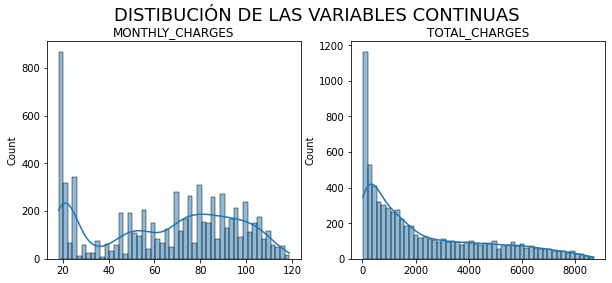

In [37]:
# REALIZAMOS UN ALGORITMO PARA MOSTRAR LA DISTRIBUCIÓN DE LAS VARIABLES CONTINUAS

continuas = ['monthly_charges', 'total_charges']

plt.figure(figsize=(10, 4))
plt.subplots_adjust(hspace=0.2)
plt.suptitle('DISTIBUCIÓN DE LAS VARIABLES CONTINUAS', fontsize=18, y=1)

ncols = 2
nrows = len(continuas) // ncols + (len(continuas) % ncols > 0)

for n, cont in enumerate(continuas):
    ax = plt.subplot(nrows, ncols, n + 1)

    sns.histplot(data=df, x=df[cont], bins=50, kde=True, ax=ax)

    ax.set_title(cont.upper())
    ax.set_xlabel('')

plt.show()

**Conclusiones Intermedias**:

* En la facturación mensual, podemos ver que la mayoría de las personas tienen cargos entre los 17USD a 25USD. Asimismo, entre los 60USD a 80USD, también existe un incremento en la distribución, pero no con la mayoría de los clientes, continuando hasta los 100USD que es cuando empieza a disminuir, ubicandose al final a 120USD que es la carga mensual más alta.


* Con respecto a las facturación totales, la gran mayoría tiene consumos entre los 0USD a 2000USD, a partir de los 4000USD en consumo es que la distribución empienza a disminuir hasta los 9000USD, que por conclusión son clientes que tiene años y planes altos.


### Distribución de las Variables Categóricas

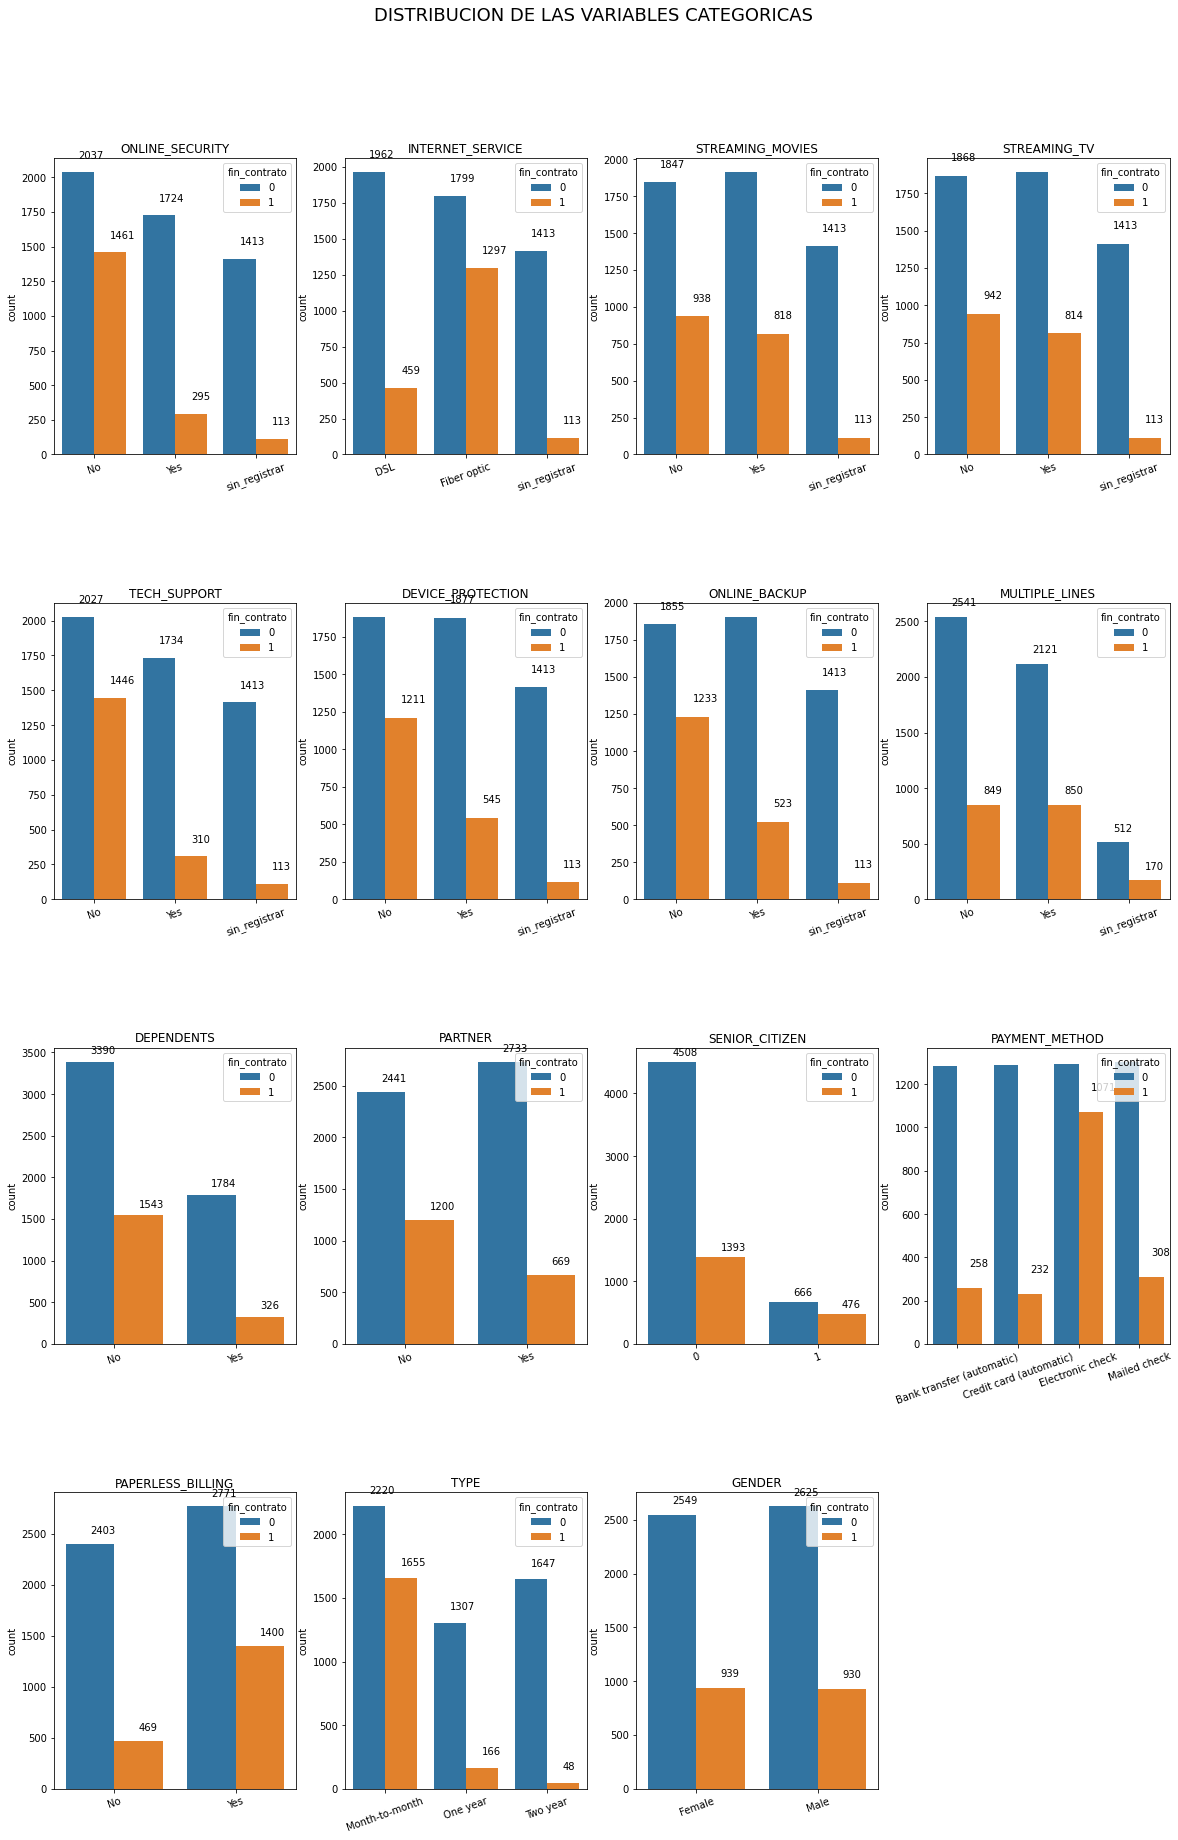

In [38]:
# REALIZAMOS UN ALGORITMO PARA MOSTRAR LA DISTRIBUCIÓN DE LAS VARIABLES CONTINUAS

categoricas = ['online_security', 
             'internet_service', 
             'streaming_movies', 
             'streaming_tv', 
             'tech_support', 
             'device_protection',
             'online_backup',
             'multiple_lines',
             'dependents',
             'partner',
             'senior_citizen',
             'payment_method',
             'paperless_billing',
             'type',
             'gender']

plt.figure(figsize=(20, 30))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('DISTRIBUCION DE LAS VARIABLES CATEGORICAS', fontsize=18, y=0.95)

ncols = 4
nrows = len(categoricas) // ncols + (len(categoricas) % ncols > 0)

for n, cat in enumerate(categoricas):
    ax = plt.subplot(nrows, ncols, n + 1)

    splot = sns.countplot(data=df, x=df[cat].sort_values(), hue=df['fin_contrato'], ax=ax)
    for p in splot.patches:
        splot.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + 0.2, p.get_height() + 100))
    ax.set_title(cat.upper())
    ax.set_xlabel('')
    plt.xticks(rotation=20)

plt.show()

**Conclusiones Intermedias**:

* En este apartado, vamos a poder responder las preguntas que anteriormente propusimos:

**1. ¿Qué tan propensos son los jubilados a finalizar contrato?**

Tenemos un 42% de los clientes actuales jubilados que han finalizado contrato mientras que de los clientes que no son jubilados y que han finalizado contrato es del 24%, es decir, casi el doble desde un estudio en los dos conjuntos. Por ende, los clientes a llegar al conjunto de jubilados, son mas propensos a finalizar contrato que al no serlo.

**2. ¿Qué clientes son más propensos a finalizar contrato? ¿Los que tienen contrato mensual o anual?**

Los clientes que van mes a mes, con un 42%, a diferencia del 11% de los clientes de contratación anual o del 3% de los clientes con contrato de dos años.

**3. ¿Cuál método de pago es el que presenta mayor índice de finalización de contrato?**

El cheque electrónico, presenta mucha finalización en correlación con los demás métodos y por mayoría.

**4. ¿Cuál es el servicio de Internet que presenta más finalización de contratos?**

La fibra óptica es la que presenta más finalización, con un 42% a diferencia de DSL y de los no registrados. 

**5. Los servicios que ofrece la empresa como soporte técnico y protección de equipos, ¿cuáles clientes tienen más finalización de contrato, los que los usan o no?**

Em ambos casos, los clientes que finalizan más contratos son los que no usan el servicio.

**6. Los clientes que poseen personas a cargo, ¿qué tendencia hay entre los que sí los tiene y los que no al finalizar contrato?**

Los clientes que no posee personas a su cargo son las que tienen tendencia a renunciar a diferencia que los que sí, podemos concluir que es por efectos de la responsabilidad.

## Plan Aproximado para la Resolución de la Tarea

1. Examinar con detenimiento que información del conjunto de datos se trabajará, específicar que columnas usaremos y cuales se desecharán. Asimismo, se decidirá cual sera la columna base para la división del conjunto de datos.

2. Aplicar modelos de Machine Learning, donde se dividan el conjunto de datos en un 80:20 para el conjunto de entrenamiento y prueba. Posteriormente se aplicaran procesos de preparación de modelos, como serán las técnicas One Hot EnCoding y el Scaling y Upsampling, si amerita el caso.

3. ¿Cuáles modelos se aplicarán? Pues, en este apartado, decidimos aplicar Regresión Logística, Arbol de Decisión, Bosque Aleatorio, CatBoost, XGBoost y las Redes Neuronales. Pensamos que con seis modelos podemos descrifrar buenos margenes en la puntuación ROC-AUC, que tiene que ser mayor al 85%.

4. De último, se concluirá mostrando y comparando los resultados arrojados por los distintos modelos aplicados, se determinará cual es el mejor modelo y se redactará una informe expresando los resultados y las recomendaciones a la empresa, para efectos de que la gerencia tome decisiones en pro de evitar más fuga de clientes.

## Preparación del Modelado

### Procesos Previos de Machine Learning

In [39]:
# ELIMINAMOS LAS COLUMNAS INNECESARIAS PARA EL NUEVO DATAFRAME

df_clean = df.drop(['customer_id', 'begin_date', 'end_date'], axis = 1)

In [40]:
# REALIZAMOS LA CODIFICACION DE LAS VARIABLES CATEGORICAS:

encoder = LabelEncoder()

private = ['dependents',
          'partner',
          'paperless_billing',
          'gender']

for val in private:
    df_clean[val] = encoder.fit_transform(df_clean[val])
    val = {index: label for index, label in enumerate(encoder.classes_)}
    print(val)

{0: 'No', 1: 'Yes'}
{0: 'No', 1: 'Yes'}
{0: 'No', 1: 'Yes'}
{0: 'Female', 1: 'Male'}


In [41]:
# PROCEDEMOS CON LA DIVISION DEL DATAFRAME EN CONJUNTOS DE ENTRENAMIENTO Y PRUEBA

X = df_clean.drop(['fin_contrato'], axis = 1)

y = df_clean['fin_contrato']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [42]:
# CREAMOS UNA COPIAS PARA EL USO DEL CATBOOST

features_train = X_train.copy()
features_test = X_test.copy()
target_train = y_train.copy()
target_test = y_test.copy()

In [43]:
# REALIAZAMOS LA CODIFICACIÓN ONE-HOT EN LAS VARIABLES CATEGORICAS

X_train = pd.get_dummies(X_train, drop_first = True)
X_test = pd.get_dummies(X_test, drop_first = True)

X_train.head()

,paperless_billing,monthly_charges,total_charges,mes_suscript,gender,senior_citizen,partner,dependents,type_One year,type_Two year,...,device_protection_Yes,device_protection_sin_registrar,tech_support_Yes,tech_support_sin_registrar,streaming_tv_Yes,streaming_tv_sin_registrar,streaming_movies_Yes,streaming_movies_sin_registrar,multiple_lines_Yes,multiple_lines_sin_registrar
2142,0,64.85,1336.80,21,0,0,0,1,1,0,...,1,0,0,0,0,0,1,0,0,0
1623,1,97.20,5129.45,54,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,1,0
6074,1,23.45,23.45,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1362,1,70.20,237.95,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6754,1,61.90,61.90,1,1,0,0,1,0,1,...,0,0,1,0,0,0,0,0,1,0


### Scaling y Upsampling

In [44]:
# REALIZAMOS EL SCALING USANDO MINMAXSCALER

col_scaling = ['monthly_charges', 'total_charges', 'mes_suscript']

scaler = MinMaxScaler()
X_train[col_scaling] = scaler.fit_transform(X_train[col_scaling])
X_test[col_scaling] = scaler.fit_transform(X_test[col_scaling])

X_train.sample(5)

,paperless_billing,monthly_charges,total_charges,mes_suscript,gender,senior_citizen,partner,dependents,type_One year,type_Two year,...,device_protection_Yes,device_protection_sin_registrar,tech_support_Yes,tech_support_sin_registrar,streaming_tv_Yes,streaming_tv_sin_registrar,streaming_movies_Yes,streaming_movies_sin_registrar,multiple_lines_Yes,multiple_lines_sin_registrar
5675,1,0.511709,0.021763,0.028571,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5885,0,0.060787,0.059970,0.314286,1,0,1,1,1,0,...,0,1,0,1,0,1,0,1,1,0
2426,1,0.173393,0.072381,0.228571,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4933,1,0.388142,0.023650,0.042857,0,0,0,1,0,0,...,1,0,0,0,1,0,1,0,0,1
2449,1,0.412556,0.076673,0.142857,1,0,1,1,0,0,...,1,0,0,0,1,0,0,0,0,0


In [45]:
# REALIZAMOS EL REMUESTREO DE DATOS USANDO SMOTE

X_upsampled, y_upsampled = SMOTE(random_state = 42).fit_resample(X_train, y_train)

X_upsampled.sample(5)

,paperless_billing,monthly_charges,total_charges,mes_suscript,gender,senior_citizen,partner,dependents,type_One year,type_Two year,...,device_protection_Yes,device_protection_sin_registrar,tech_support_Yes,tech_support_sin_registrar,streaming_tv_Yes,streaming_tv_sin_registrar,streaming_movies_Yes,streaming_movies_sin_registrar,multiple_lines_Yes,multiple_lines_sin_registrar
7485,0,0.270602,0.003070,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4876,1,0.074738,0.099671,0.485714,0,0,1,1,0,0,...,0,1,0,1,0,1,0,1,1,0
7491,0,0.569887,0.040689,0.049156,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1596,0,0.721973,0.156485,0.214286,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
7944,1,0.554867,0.264942,0.430584,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Procesos Previos para el Modelo Catboost

In [46]:
# # REALIZAMOS LA CODIFICACION DE LAS VARIABLES CATEGORICAS:

encoder = LabelEncoder()

col_label = ['type',
            'payment_method',
            'internet_service',
            'online_security',
            'online_backup',
            'device_protection',
            'tech_support',
            'streaming_tv',
            'streaming_movies',
            'multiple_lines']

for col in col_label:
    features_train[col] = encoder.fit_transform(features_train[col])
    features_test[col] = encoder.fit_transform(features_test[col])
    col = {index: label for index, label in enumerate(encoder.classes_)}
    print(col)

{0: 'Month-to-month', 1: 'One year', 2: 'Two year'}
{0: 'Bank transfer (automatic)', 1: 'Credit card (automatic)', 2: 'Electronic check', 3: 'Mailed check'}
{0: 'DSL', 1: 'Fiber optic', 2: 'sin_registrar'}
{0: 'No', 1: 'Yes', 2: 'sin_registrar'}
{0: 'No', 1: 'Yes', 2: 'sin_registrar'}
{0: 'No', 1: 'Yes', 2: 'sin_registrar'}
{0: 'No', 1: 'Yes', 2: 'sin_registrar'}
{0: 'No', 1: 'Yes', 2: 'sin_registrar'}
{0: 'No', 1: 'Yes', 2: 'sin_registrar'}
{0: 'No', 1: 'Yes', 2: 'sin_registrar'}


In [47]:
# REALIZAMOS EL SCALING USANDO MINMAXSCALER

col_scale = ['monthly_charges', 'total_charges', 'mes_suscript']

scaler = MinMaxScaler()
features_train[col_scale] = scaler.fit_transform(features_train[col_scale])
features_test[col_scale] = scaler.fit_transform(features_test[col_scale])

features_train.sample(5)

,type,paperless_billing,payment_method,monthly_charges,total_charges,mes_suscript,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
260,0,1,2,0.228201,0.013086,0.028571,0,0,0,1,0,0,1,1,1,0,0,2
3767,2,1,1,0.923269,0.948771,1.000000,1,1,0,1,1,1,1,1,0,1,0,1
445,0,1,2,0.873443,0.735939,0.828571,1,0,1,1,0,1,1,0,0,0,0,1
3937,0,1,1,0.018934,0.005729,0.042857,2,2,2,2,2,2,2,0,0,0,0,0
4963,2,0,2,0.551570,0.404321,0.657143,0,0,1,1,0,1,1,1,0,1,0,0


In [48]:
# REALIZAMOS EL REMUESTREO DE DATOS USANDO SMOTE

features_train, target_train = SMOTE(random_state = 42).fit_resample(features_train, target_train)

target_train.value_counts()

0    4138
1    4138
Name: fin_contrato, dtype: int64

## Entrenamiento de los Modelos

In [56]:
# CREAMOS LA FUNCIÓN PARA LA COMPARACION DE DISTINTOS MODELOS

def creacion_modelo(seed = 42):
    
    models = []
    models.append(('DUMMY CLASSIFIER', DummyClassifier(random_state = seed, strategy = 'most_frequent')))
    models.append(('REGRESION LOGISTICA', LogisticRegression(random_state = seed)))
    models.append(('ARBOL DE DECISION', DecisionTreeClassifier(random_state = seed)))
    models.append(('BOSQUE ALEATORIO', RandomForestClassifier(random_state = seed)))
    models.append(('CATBOOST', CatBoostClassifier(random_state = seed, verbose = False)))
    models.append(('GRADIENT BOOSTING', XGBClassifier(random_state =seed)))
                  
    return models
                  
models = creacion_modelo()

In [58]:
%%time

# CREAMOS LA EVALUACION DE LOS MODELOS

results = defaultdict(list)

scoring = 'ROC_AUC'

for name, model in models:
    
    model.fit(X_upsampled, y_upsampled)
    predictions_train = model.predict(X_upsampled)
    predictions_test = model.predict(X_test)
    roc_auc_train = roc_auc_score(y_upsampled, predictions_train)
    roc_auc_test = roc_auc_score(y_test, predictions_test)
    
    results['NOMBRE'].append(name)
    results['ROC-AUC DE ENTRENAMIENTO'].append(roc_auc_train)
    results['ROC-AUC DE PRUEBA'].append(roc_auc_test)
    
display(pd.DataFrame(results))

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:17:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,NOMBRE,ROC-AUC DE ENTRENAMIENTO,ROC-AUC DE PRUEBA
0,DUMMY CLASSIFIER,0.500000,0.500000
1,REGRESION LOGISTICA,0.789874,0.774571
2,ARBOL DE DECISION,0.999033,0.688459
3,BOSQUE ALEATORIO,0.999033,0.749213
4,CATBOOST,0.895723,0.768731
5,GRADIENT BOOSTING,0.943330,0.755540


CPU times: user 11 s, sys: 315 ms, total: 11.4 s
Wall time: 11.7 s


**Conclusiones intermedias**:

* Tenemos que los modelos de Regresión Logística, Catboost y Gradient Boosting son los que tienen mejor rendimiento con respecto al ROC-AUC en el conjunto de prueba, pero no es suficiente, lo cual nos llevara a considerar otras tecnicas y metricas que se aplicaran a continuación...


### Evaluación del Modelo

In [62]:
def evaluacion_modelo(model, X_train, y_train, X_test, y_test):
    cv = KFold(n_splits = 10, random_state = 42, shuffle = True)
    scores = cross_val_score(model, X_train, y_train, scoring = 'roc_auc', cv = cv, n_jobs = -1)
    scores = np.abs(scores)
    print('PROMEDIO ROC-AUC DE ENTRENAMIENTO K-FOLD:', scores.mean())
    
    model.fit(X_train, y_train)
    y_test_predict = model.predict(X_test)
    print('PRUEBA ROC-AUC:', roc_auc_score(y_test, y_test_predict))
    print('PRUEBA DE PRECISION:', accuracy_score(y_test, y_test_predict))
    
    probabilities_valid = model.predict_proba(X_test)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_valid)
    auc_roc = roc_auc_score(y_test, probabilities_one_valid)
    
    print()
    
    plt.figure(figsize = (3, 3))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('TASA DE FALSOS POSITIVOS')
    plt.ylabel('TASA DE VERDADEROS POSITIVOS')
    plt.title('CURVA ROC')
    plt.show()
    
    return

In [63]:
def grafica_modelo(importance, names, model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
    
    plt.figure(figsize = (6, 5))
    sns.barplot(x = fi_df['feature_importance'], y = fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('IMPORTANCIA DE CARACTERÍSTICAS')
    plt.ylabel('NOMBRE DE CARACTERÍSTICAS')

### Regresión Logística

PROMEDIO ROC-AUC DE ENTRENAMIENTO K-FOLD: 0.8712311800397934
PRUEBA ROC-AUC: 0.7745712008446592
PRUEBA DE PRECISION: 0.7643718949609652



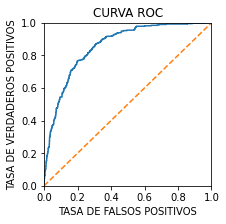

In [64]:
# CREAMOS Y EVALUAMOS EL MODELO

model_lr = LogisticRegression()

evaluacion_modelo(model_lr, X_upsampled, y_upsampled, X_test, y_test)

In [65]:
# ENTRENAMOS EL MODELO Y EVALUMOS LAS PREDICCIONES

lr_model = LogisticRegression()

lr_model.fit(X_upsampled, y_upsampled)
y_train_predict = lr_model.predict(X_upsampled)
y_test_predict = lr_model.predict(X_test)

roc_auc_train = roc_auc_score(y_upsampled, y_train_predict)
roc_auc_test = roc_auc_score(y_test, y_test_predict)

print("MODELO DE REGRESION LOGISTICA ENTRENADO Y EVALUADO:")
print("ROC-AUC EN EL CONJUNTO DE ENTRENAMIENTO:", roc_auc_train)
print("ROC-AUC EN EL CONJUNTO DE PRUEBA:", roc_auc_test)

MODELO DE REGRESION LOGISTICA ENTRENADO Y EVALUADO:
ROC-AUC EN EL CONJUNTO DE ENTRENAMIENTO: 0.789874335427743
ROC-AUC EN EL CONJUNTO DE PRUEBA: 0.7745712008446592


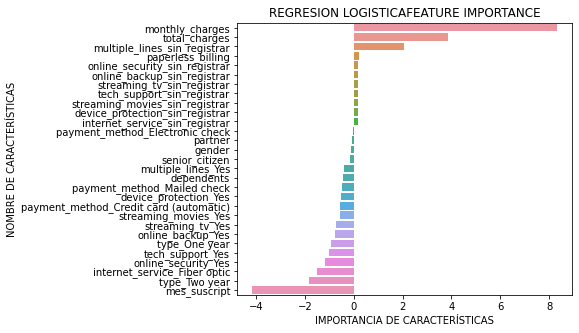

In [66]:
# VISUALIZAMOS LA IMPORTANCIA DE LAS CARACTERISTICAS

grafica_modelo(model_lr.coef_[0], X_upsampled.columns, 'REGRESION LOGISTICA')

**Conclusiones Intermedias**:

* Tenemos que el promedio ROC-AUC KFOLD es significativo con un 0.87, mientras que sin usarlo presentamos un ROC-AUC de 0.77 y de precision de 0.76, lo cual mencionamos que tiene buen rendimiento.

* Con respecto a la gráfica, las caracteristicas mas positivas son la facturacion mensual y la facturacion total, mientras que la mas negativas son el mes de suscripcion y el tipo de suscripcion de dos años.

### Arbol de Decision

In [68]:
%%time

# DETERMINAMOS EL MEJOR PARAMETRO USANDO GRIDSEARCHCV

dt_grid = DecisionTreeClassifier()

dt_parameters = {'max_depth': [4, 5, 6],
                 'max_features': ['sqrt', 'log2'], 
                 'criterion': ['gini', 'entropy']}

dt_search = GridSearchCV(estimator=dt_grid,
                         param_grid=dt_parameters,
                         scoring='roc_auc',
                         n_jobs=-1,  
                         cv=10,     
                         verbose=True)

dt_search.fit(X_train, y_train)

print("Mejores parámetros:", dt_search.best_params_)


Fitting 10 folds for each of 12 candidates, totalling 120 fits
Mejores parámetros: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt'}
CPU times: user 1.58 s, sys: 0 ns, total: 1.58 s
Wall time: 1.58 s


PROMEDIO ROC-AUC DE ENTRENAMIENTO K-FOLD: 0.8298273899031665
PRUEBA ROC-AUC: 0.715965199209167
PRUEBA DE PRECISION: 0.7324343506032647



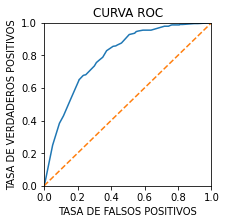

In [70]:
# CREAMOS Y EVALUAMOS EL MODELO

dt_model = DecisionTreeClassifier(criterion = 'gini', max_depth = 6, max_features = 'sqrt')

evaluacion_modelo(dt_model, X_upsampled, y_upsampled, X_test, y_test)

In [71]:
# ENTRENAMOS EL MODELO Y EVALUMOS LAS PREDICCIONES

dt_model.fit(X_upsampled, y_upsampled)
y_train_predict = dt_model.predict(X_upsampled)
y_test_predict = dt_model.predict(X_test)

roc_auc_train = roc_auc_score(y_upsampled, y_train_predict)
roc_auc_test = roc_auc_score(y_test, y_test_predict)

print("MODELO DE ARBOL DE DECISION ENTRENADO Y EVALUADO:")
print("ROC-AUC EN EL CONJUNTO DE ENTRENAMIENTO:", roc_auc_train)
print("ROC-AUC EN EL CONJUNTO DE PRUEBA:", roc_auc_test)

MODELO DE ARBOL DE DECISION ENTRENADO Y EVALUADO:
ROC-AUC EN EL CONJUNTO DE ENTRENAMIENTO: 0.7548332527791204
ROC-AUC EN EL CONJUNTO DE PRUEBA: 0.7464184789922056


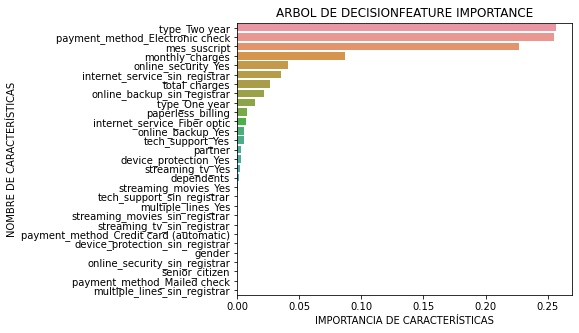

In [72]:
# VISUALIZAMOS LA IMPORTANCIA DE LAS CARACTERISTICAS

grafica_modelo(dt_model.feature_importances_, X_upsampled.columns, 'ARBOL DE DECISION')

**Conclusiones Intermedias**:

* Usando la herramienta GRIDSEARCHCV, tenemos como resultado un promedio ROC-AUC K-FOLD de 0.82 y sin el, un ROC-AUC de 0.71 y de precision de 0.73, tambien resultados razonables para este modelo.

* Con respecto a la gráfica, tenemos que las carateristicas mas notables son todas positivas y son el tipo de contrato de dos años y el tipo de pago, siendo el cheque electronico.



### Bosque Aleatorio

In [73]:
%%time

# DETERMINAMOS EL MEJOR PARAMETRO USANDO GRIDSEARCHCV

rf_grid = RandomForestClassifier()

rf_parameters = {'n_estimators': [200, 500],
                'max_features': [1, 2, 3, 'sqrt', 'log2'],
                'max_depth': [4, 5, 6, 7, 8],
                'criterion': ['gini', 'entropy']}

rf_search = GridSearchCV(estimator = rf_grid, 
                         param_grid = rf_parameters, 
                         scoring = 'roc_auc', 
                         n_jobs = 10, 
                         cv = 10, 
                         verbose = True)

rf_search.fit(X_upsampled, y_upsampled)

print(rf_search.best_params_)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
{'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 500}
CPU times: user 9.34 s, sys: 664 ms, total: 10 s
Wall time: 39min 13s


PROMEDIO ROC-AUC DE ENTRENAMIENTO K-FOLD: 0.8766347350825363
PRUEBA ROC-AUC: 0.7766621466353371
PRUEBA DE PRECISION: 0.7636621717530163



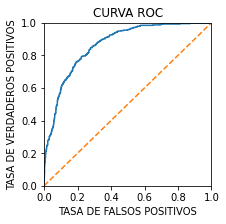

In [74]:
# CREAMOS Y EVALUAMOS EL MODELO

rf_model = RandomForestClassifier(criterion = 'gini', max_depth = 8, max_features = 'sqrt', n_estimators = 500)

evaluacion_modelo(rf_model, X_upsampled, y_upsampled, X_test, y_test)

In [75]:
# ENTRENAMOS EL MODELO Y EVALUMOS LAS PREDICCIONES

rf_model.fit(X_upsampled, y_upsampled)
y_train_predict = rf_model.predict(X_upsampled)
y_test_predict = rf_model.predict(X_test)

roc_auc_train = roc_auc_score(y_upsampled, y_train_predict)
roc_auc_test = roc_auc_score(y_test, y_test_predict)

print("MODELO DE BOSQUE ALEATORIO ENTRENADO Y EVALUADO:")
print("ROC-AUC EN EL CONJUNTO DE ENTRENAMIENTO:", roc_auc_train)
print("ROC-AUC EN EL CONJUNTO DE PRUEBA:", roc_auc_test)

MODELO DE BOSQUE ALEATORIO ENTRENADO Y EVALUADO:
ROC-AUC EN EL CONJUNTO DE ENTRENAMIENTO: 0.8286611889801837
ROC-AUC EN EL CONJUNTO DE PRUEBA: 0.7820240769302432


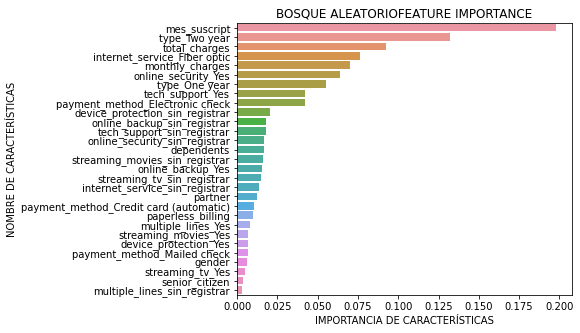

In [76]:
# VISUALIZAMOS LA IMPORTANCIA DE LAS CARACTERISTICAS

grafica_modelo(rf_model.feature_importances_, X_upsampled.columns, 'BOSQUE ALEATORIO')

**Conclusiones Intermedias**:

* De igual manera usando la herramienta GRIDSEARCHCV, tenemos como resultado un promedio ROC-AUC K-FOLD de 0.87 y sin el, un ROC-AUC de 0.77 y de precision de 0.76, tambien resultados razonables para este modelo y mejorando los dos anteriores. Por los momentos es el mejor modelo.

* Con respecto a la gráfica, igualmente presentamos todas las caracteristicas en positivo siendo las mas significativas el mes de suscripcion y el tipo de contrato de dos años.


### CatBoost

PROMEDIO ROC-AUC DE ENTRENAMIENTO K-FOLD: 0.9254457513724716
PRUEBA ROC-AUC: 0.754361743973004
PRUEBA DE PRECISION: 0.7977288857345636



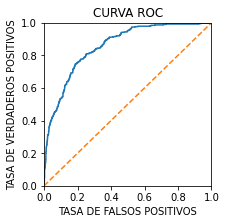

In [77]:
# CREAMOS Y EVALUAMOS EL MODELO

catboost_model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=0)

evaluacion_modelo(catboost_model, X_upsampled, y_upsampled, X_test, y_test)


In [78]:
# ENTRENAMOS EL MODELO Y EVALUMOS LAS PREDICCIONES

catboost_model.fit(X_upsampled, y_upsampled)
y_train_predict = catboost_model.predict(X_upsampled)
y_test_predict = catboost_model.predict(X_test)

roc_auc_train = roc_auc_score(y_upsampled, y_train_predict)
roc_auc_test = roc_auc_score(y_test, y_test_predict)

print("MODELO DE CATBOOST ENTRENADO Y EVALUADO:")
print("ROC-AUC EN EL CONJUNTO DE ENTRENAMIENTO:", roc_auc_train)
print("ROC-AUC EN EL CONJUNTO DE PRUEBA:", roc_auc_test)

MODELO DE CATBOOST ENTRENADO Y EVALUADO:
ROC-AUC EN EL CONJUNTO DE ENTRENAMIENTO: 0.9352344127597874
ROC-AUC EN EL CONJUNTO DE PRUEBA: 0.754361743973004


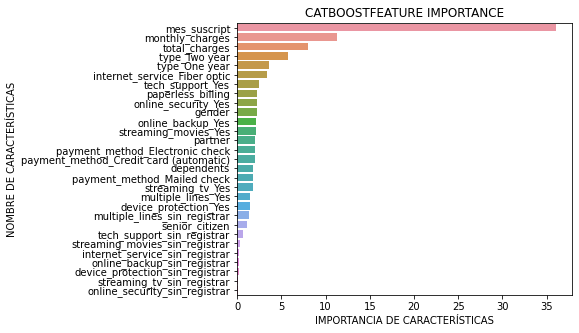

In [79]:
# VISUALIZAMOS LA IMPORTANCIA DE LAS CARACTERISTICAS

grafica_modelo(catboost_model.feature_importances_, X_upsampled.columns, 'CATBOOST')

**Conclusiones Intermedias**:

* En este modelo, no aplicamos el mejor parametro por tema de recursos, pero colocando nosotros los parametros pertinentes, tenemos un promedio ROC-AUC KFOLD muy significativo de 0.92 y unas pruebas ROC-AUC y de precision de 0.75 y 0.79 respectivamente.

* Con respecto a la grafica, tenemos todas las caracterisitcas en positivo siendo las mas significativas el mes de suscripcion y la facturacion mensual.

### XGBoost

PROMEDIO ROC-AUC DE ENTRENAMIENTO K-FOLD: 0.9024922912177255
PRUEBA ROC-AUC: 0.7727506805925037
PRUEBA DE PRECISION: 0.7856635911994322



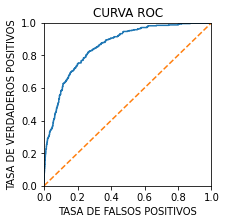

In [84]:
# CREAMOS Y EVALUAMOS EL MODELO

xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, verbosity=0, use_label_encoder=False)

evaluacion_modelo(xgb_model, X_upsampled, y_upsampled, X_test, y_test)


In [85]:
# ENTRENAMOS EL MODELO Y EVALUMOS LAS PREDICCIONES

xgb_model.fit(X_upsampled, y_upsampled)
y_train_predict = xgb_model.predict(X_upsampled)
y_test_predict = xgb_model.predict(X_test)

roc_auc_train = roc_auc_score(y_upsampled, y_train_predict)
roc_auc_test = roc_auc_score(y_test, y_test_predict)

print("MODELO DE XGBOOST ENTRENADO Y EVALUADO:")
print("ROC-AUC EN EL CONJUNTO DE ENTRENAMIENTO:", roc_auc_train)
print("ROC-AUC EN EL CONJUNTO DE PRUEBA:", roc_auc_test)

MODELO DE XGBOOST ENTRENADO Y EVALUADO:
ROC-AUC EN EL CONJUNTO DE ENTRENAMIENTO: 0.8761478975350411
ROC-AUC EN EL CONJUNTO DE PRUEBA: 0.7727506805925037


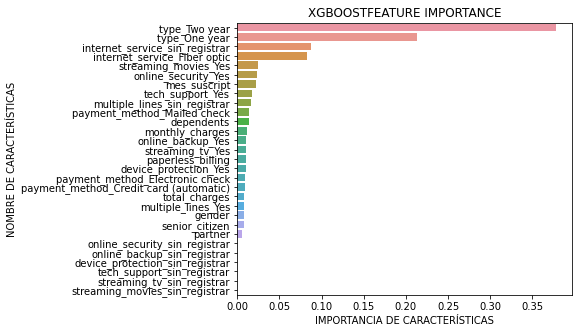

In [86]:
grafica_modelo(xgb_model.feature_importances_, X_upsampled.columns, 'XGBOOST')

**Conclusiones Intermedias**:

* Igual que en el modelo CatBoost, tenemos datos mas razonables como un promedio ROC-AUC KFOLD DE 0.90 y una prueba ROC-AUC y de precision de 0.77 y 0.78 respectivamente.

* Con respecto a la grafica, igualmente las caracteristicas en positivo siendo las mas significativas los tipos de contratacion, la primera de dos años y la segunda el contrato por un año.

### Redes Neuronales

In [94]:
# CREAMOS Y EVALUAMOS EL MODELO 1

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

model_ann_1 = keras.Sequential([
    keras.layers.Dense(26, activation = 'relu'),
    keras.layers.Dense(15, activation = 'relu'),
    keras.layers.Dense(units = 1, activation = 'sigmoid')
])

optimizer = Adam(lr = 0.0001)
model_ann_1.compile(optimizer = optimizer,
                   loss = 'binary_crossentropy',
                   metrics = ['AUC', 'accuracy'])

model_ann_1.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
177/177 [==============================] - 2s 5ms/step - loss: 0.5985 - auc: 0.5612 - accuracy: 0.7240 - val_loss: 0.5620 - val_auc: 0.6718 - val_accuracy: 0.7246
Epoch 2/30
177/177 [==============================] - 1s 4ms/step - loss: 0.5400 - auc: 0.7057 - accuracy: 0.7320 - val_loss: 0.5078 - val_auc: 0.7729 - val_accuracy: 0.7353
Epoch 3/30
177/177 [==============================] - 1s 4ms/step - loss: 0.5009 - auc: 0.7687 - accuracy: 0.7393 - val_loss: 0.4737 - val_auc: 0.8098 - val_accuracy: 0.7417
Epoch 4/30
177/177 [==============================] - 1s 4ms/step - loss: 0.4769 - auc: 0.7936 - accuracy: 0.7551 - val_loss: 0.4535 - val_auc: 0.8251 - val_accuracy: 0.7644
Epoch 5/30
177/177 [==============================] - 1s 4ms/step - loss: 0.4623 - auc: 0.8067 - accuracy: 0.7696 - val_loss: 0.4407 - val_auc: 0.8336 - val_accuracy: 0.7835
Epoch 6/30
177/177 [==============================] - 1s 4ms/step - loss: 0.4530 - auc: 0.8141 - accuracy: 0.7803 - val_loss: 0.43

In [92]:
# CREAMOS Y EVALUAMOS EL MODELO 2

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Flatten, Dense, InputLayer

model_ann_2 = keras.Sequential()
model_ann_2.add(InputLayer(input_shape = X_train.shape[1:]))
model_ann_2.add(Dense(10, activation = 'relu'))
model_ann_2.add(Dense(5, activation = 'tanh'))
model_ann_2.add(Dense(1, activation = 'sigmoid'))

optimizer = Adam(lr = 0.0001)
model_ann_2.compile(optimizer = optimizer,
                   loss = 'binary_crossentropy',
                   metrics = ['AUC', 'accuracy'])

model_ann_2.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
177/177 [==============================] - 2s 6ms/step - loss: 0.6035 - auc: 0.5626 - accuracy: 0.7128 - val_loss: 0.5816 - val_auc: 0.5988 - val_accuracy: 0.7282
Epoch 2/30
177/177 [==============================] - 1s 4ms/step - loss: 0.5597 - auc: 0.6527 - accuracy: 0.7309 - val_loss: 0.5437 - val_auc: 0.6888 - val_accuracy: 0.7381
Epoch 3/30
177/177 [==============================] - 1s 4ms/step - loss: 0.5332 - auc: 0.7109 - accuracy: 0.7364 - val_loss: 0.5201 - val_auc: 0.7373 - val_accuracy: 0.7431
Epoch 4/30
177/177 [==============================] - 1s 4ms/step - loss: 0.5164 - auc: 0.7415 - accuracy: 0.7410 - val_loss: 0.5036 - val_auc: 0.7649 - val_accuracy: 0.7480
Epoch 5/30
177/177 [==============================] - 1s 4ms/step - loss: 0.5040 - auc: 0.7600 - accuracy: 0.7441 - val_loss: 0.4902 - val_auc: 0.7830 - val_accuracy: 0.7473
Epoch 6/30
177/177 [==============================] - 1s 4ms/step - loss: 0.4939 - auc: 0.7737 - accuracy: 0.7487 - val_loss: 0.47

In [95]:
print('MODELO 1', model_ann_1.evaluate(X_test, y_test))
print('MODELO 2', model_ann_2.evaluate(X_test, y_test))

45/45 [==============================] - 0s 2ms/step - loss: 0.4071 - auc: 0.8549 - accuracy: 0.8098
MODELO 1 [0.40707650780677795, 0.854857861995697, 0.8097941875457764]
45/45 [==============================] - 0s 2ms/step - loss: 0.4141 - auc: 0.8516 - accuracy: 0.8062
MODELO 2 [0.41413912177085876, 0.8516204357147217, 0.8062455654144287]


**Conclusiones Intermedias**:

* Con respecto a este modelo, se aplicaron sus parametros y su tratamiento en particular, ademas de aplicar dos modelos. Los resultados son que en el primero modelo tenemos un ROC-AUC DE 0.855 y para el segundo de 0.852, siendo mejor el primero modelo.Tambien tenemos datos como una precision para el primer modelo del 80.9% y de 80.6% para el segundo, datos que nos dan un rendimiendo razonable en terminos de ROC-AUC Y precision.

* Ahora bien, de los modelos anteriormente trabajados, por resultados, el mejor modelo a usar es el PRIMER MODELO de Redes Neuronales.

**Del punto 5, tenemos los siguientes comentarios**:

1. Se examinó el conjunto de datos, y se aplicaron codigos para mejorar el trabajo de la división de ese mismo conjunto de datos. Se pueden observar en el apartado 6.

2. Al aplicar los modelos de Machine Learning, se procedió a realizar las técnicas antes mencionadas, e inclusive se implementó una nueva libreria para efectos de comodidad.

3. Se aplicaron los modelos anteriormente expuestos, siendo los mejores Redes Neuronales, CatBoost y Regresión Logistica, dandonos el primero un ROC-AUC en el conjunto de datos de prueba del 85%.

4. Se dieron conclusiones intermedias en cada aplicación de cada modelo, lo cual nos da un esbozo de los resultados obtenidos para adentrarnos en las conclusiones finales y recomendaciones para la gerencia de la empresa.
